In [103]:
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import re
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
plt.style.use(style="seaborn")
%matplotlib inline

### Loading the Data

In [4]:
all_df = pd.DataFrame()
for path, subdirs, files in os.walk('resource'):
    for name in files:
        csv_file_path = os.path.join(path, name)
        df = pd.read_csv(csv_file_path)
        all_df = all_df.append(df)

In [5]:
dataframe = all_df.copy()

In [104]:
# csv_file_path = ('data/kickstarter_data_with_features.csv')
# dataframe = pd.read_csv(csv_file_path)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29,30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Defining  some functions

In [105]:
# Multiple functions for cleaning data 

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_number(text):
    newstring = re.sub(r'[0-9]+', '', text)
    return newstring


def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)


def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def remove_stopwords(text):
    # nltk.download('stopwords') 
    stop = set(stopwords.words("english"))
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)


def get_vocab_size(text):
    """Count unique words"""
    count = Counter()
    for i in text.values:
        i = remove_punct(i)
        i = remove_emoji(i)
        i = remove_URL(i)
        i = remove_html(i)
        i = remove_number(i)
        for word in i.split():
            count[word] += 1
    return len(count)

### Preprocessing the data

In [106]:
dataframe['blurb']=dataframe['blurb'].astype("string") 
dataframe = dataframe[['blurb','state', 'pledged']] # only using these 2 cols
dataframe = dataframe[dataframe['state'].isin(['successful', 'failed'])]
dataframe['state'] = dataframe['state'].replace({'failed': 0, 'successful': 1})
dataframe = dataframe.dropna() 
dataframe['blurb'] = dataframe['blurb'].map(remove_stopwords) # remove stop words

In [107]:
dataframe

,blurb,state,pledged
0,mts asl curriculum workbook reproducible study...,0,0.0
1,"kit teaches print, correct ugly grasp, make su...",0,0.0
2,"establishing free, world-class, public library...",0,120.0
3,goal: introducing new word english language/di...,0,0.0
4,zu den artikeln der dsgvo sind die korrespondi...,0,356.0
...,...,...,...
20627,"easy way present story time anytime, wherever ...",0,25868.0
20628,revolutionary app makes getting fit easy effic...,0,1559.0
20629,"love fatbooth ugly booth, see look three toed ...",0,0.0
20630,production android app cab drivers truckers.,0,0.0


### Splitting the Data

In [108]:
from sklearn.model_selection import train_test_split
X = dataframe.drop(['state', 'pledged'], axis=1)
Y = dataframe[['state', 'pledged']]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=123)

### Getting the Vocabular size: # of unique words

In [109]:
train_v_size = get_vocab_size(X_train.blurb)

In [110]:
train_v_size

23927

### Sequencing the text

Fitting a tokenizer to assign indices to words and converting the text to sequence of indices.

In [111]:
#fit tokenizer on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.blurb)
#get train sequences
train_seqs = tokenizer.texts_to_sequences(X_train.blurb)
train_seqs_max_size = max([len(seq) for seq in train_seqs])
#get test sequences
test_seqs = tokenizer.texts_to_sequences(X_test.blurb)
test_seqs_max_size = max([len(seq) for seq in test_seqs])

In [112]:
train_seqs_max_size, test_seqs_max_size

(26, 23)

### Padding the sequences

Padding the sequences to have seqencies of equal length. 

In [113]:
train_padded = pad_sequences(train_seqs, maxlen=train_seqs_max_size, padding="post", truncating="post")
test_padded = pad_sequences(test_seqs, maxlen=train_seqs_max_size, padding="post", truncating="post")

In [114]:
print(f"Shape of train {train_padded.shape}")
print(f"Shape of test {test_padded.shape}")

Shape of train (12203, 26)
Shape of test (5231, 26)


### Embeddings

In [115]:
documents = X_train.blurb
X_train_tokenized = [[word for word in document.lower().split()] for document in documents]

#### Word2Vec

In [17]:
from gensim.models import Word2Vec, FastText
word_model = Word2Vec(X_train_tokenized, vector_size=100)

#build matrix 
embedding_matrix_w2v = np.random.random(((train_v_size) + 1, 100))
for word,i in tokenizer.word_index.items():  
    try:
        embedding_matrix_ft[i] = word_model.wv[word]
    except:
        pass

# create layer
embedding_layer_w2v = Embedding((train_v_size) + 1, output_dim=100, 
                            weights=[embedding_matrix_w2v], trainable=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


#### FastText

In [116]:
ft = FastText(vector_size=300)
ft.build_vocab(X_train_tokenized)
ft.train(tokenizer.word_index, total_examples=ft.corpus_count, epochs=10)

# build matrix
embedding_matrix_ft = np.random.random(((train_v_size) + 1, ft.vector_size))
for word,i in tokenizer.word_index.items(): 
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pass

# create layer
embedding_layer_ft = Embedding((train_v_size) + 1, output_dim=300, 
                            weights=[embedding_matrix_ft], trainable=True)

#### Keras Embeddings 

In [19]:
embedding_layer_keras = Embedding(train_v_size, output_dim=100, input_length=train_seqs_max_size)

### Modeling

In [117]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from keras.initializers import Constant
from keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L2

In [118]:
def lstm_model(embeddings, classification=True):
    model = Sequential()
    model.add(embeddings)
    model.add(LSTM(20, dropout=.9))
    model.add(Dense(1, activation="sigmoid"))

    adam_opt = Adam(learning_rate=3e-4)
    if classification:
        model.compile(loss="binary_crossentropy", optimizer=adam_opt, metrics=["accuracy"])
    else: 
        model.compile(loss="mean_squared_error", optimizer=adam_opt, metrics=["mse"])
        
    return model 

def train_model(model, train_padded, test_padded, y_train, y_test):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit( train_padded, y_train, epochs=20,
                            validation_data=(test_padded, y_test), callbacks=[early_stopping])
    
    return history
    
    
def evaluate_model(model, test_padded, y_test):
    results = model.evaluate(test_padded, y_test, batch_size=128)
    return results 

def plot_history(history, loss):
    if loss:
        x, y = 'loss', 'val_loss'
        title = 'Loss Vs Val_loss'
        y_label = 'Loss'
    else: 
        x, y = 'accuracy', 'val_accuracy'
        title = 'Accuracy Vs VAl_accuracy'
        y_label = 'Accuracy'
        
    plt = history[[x, y]].plot(lw=2, colormap='jet', marker='.', markersize=10, title=title)
    plt.set_xlabel('Epochs')
    plt.set_ylabel(y_label)
    

### LSTM

#### LSTM -  Predict if a project/campaign will be successful or not

##### Keras Embeddings

In [24]:
model = lstm_model(embedding_layer_keras)    
history = train_model(model, train_padded, test_padded, y_train['state'], y_test['state'])

Epoch 1/20
4562/4562 [==============================] - 671s 146ms/step - loss: 0.6389 - accuracy: 0.6463 - val_loss: 0.5551 - val_accuracy: 0.7107
Epoch 2/20
4562/4562 [==============================] - 560s 123ms/step - loss: 0.5516 - accuracy: 0.7188 - val_loss: 0.5439 - val_accuracy: 0.7206
Epoch 3/20
4562/4562 [==============================] - 529s 116ms/step - loss: 0.5319 - accuracy: 0.7341 - val_loss: 0.5350 - val_accuracy: 0.7302
Epoch 4/20
4562/4562 [==============================] - 514s 113ms/step - loss: 0.5188 - accuracy: 0.7451 - val_loss: 0.5415 - val_accuracy: 0.7303
Epoch 5/20
4562/4562 [==============================] - 531s 116ms/step - loss: 0.5113 - accuracy: 0.7496 - val_loss: 0.5494 - val_accuracy: 0.7249
Epoch 6/20
4562/4562 [==============================] - 589s 129ms/step - loss: 0.5054 - accuracy: 0.7557 - val_loss: 0.5354 - val_accuracy: 0.7332


In [25]:
keras_lstm_status_history = pd.DataFrame(history.history)
keras_lstm_status_history

,loss,accuracy,val_loss,val_accuracy
0,0.607656,0.672678,0.555070,0.710737
1,0.548978,0.721296,0.543935,0.720584
2,0.531263,0.734903,0.535012,0.730161
3,0.520279,0.742665,0.541542,0.730256
4,0.512031,0.749373,0.549408,0.724885
5,0.505534,0.754868,0.535381,0.733198


In [26]:
evaluate_model(model, test_padded, y_test['state'])

489/489 [==============================] - 4s 9ms/step - loss: 0.5350 - accuracy: 0.7302


[0.5350123643875122, 0.7301605343818665]

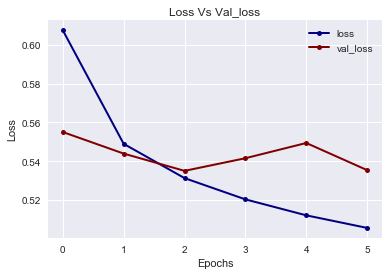

In [88]:
plot_history(keras_lstm_status_history, loss=True)

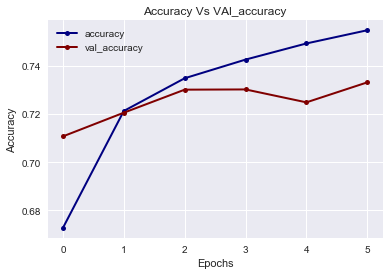

In [89]:
plot_history(keras_lstm_status_history, loss=False)

##### Word2Vec 

In [94]:
model = lstm_model(embedding_layer_w2v)    
history = train_model(model, train_padded, test_padded, y_train['state'], y_test['state'])

Epoch 1/20
4562/4562 [==============================] - 667s 145ms/step - loss: 0.6681 - accuracy: 0.6179 - val_loss: 0.6581 - val_accuracy: 0.6323
Epoch 2/20
4562/4562 [==============================] - 668s 146ms/step - loss: 0.6589 - accuracy: 0.6324 - val_loss: 0.6577 - val_accuracy: 0.6323
Epoch 3/20
4562/4562 [==============================] - 707s 155ms/step - loss: 0.6591 - accuracy: 0.6315 - val_loss: 0.6578 - val_accuracy: 0.6323
Epoch 4/20
4562/4562 [==============================] - 677s 148ms/step - loss: 0.6587 - accuracy: 0.6314 - val_loss: 0.6580 - val_accuracy: 0.6323
Epoch 5/20
4562/4562 [==============================] - 718s 157ms/step - loss: 0.6597 - accuracy: 0.6290 - val_loss: 0.6578 - val_accuracy: 0.6323


In [95]:
w2v_lstm_status_history = pd.DataFrame(history.history)
w2v_lstm_status_history

,loss,accuracy,val_loss,val_accuracy
0,0.663493,0.627424,0.658084,0.632274
1,0.659444,0.631144,0.657738,0.632274
2,0.659048,0.631144,0.657767,0.632274
3,0.658751,0.631144,0.657965,0.632274
4,0.658599,0.631144,0.657788,0.632274


In [96]:
evaluate_model(model, test_padded, y_test['state'])

489/489 [==============================] - 8s 16ms/step - loss: 0.6577 - accuracy: 0.6323


[0.6577392220497131, 0.6322739720344543]

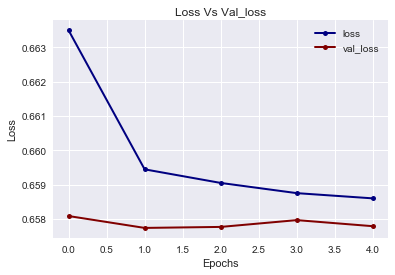

In [100]:
plot_history(w2v_lstm_status_history, loss=True)

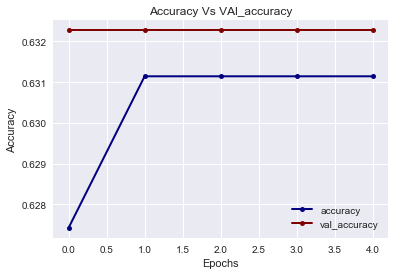

In [101]:
plot_history(w2v_lstm_status_history, loss=False)

##### FastText

In [119]:
model = lstm_model(embedding_layer_ft)    
history = train_model(model, train_padded, test_padded, y_train['state'], y_test['state'])

Epoch 1/20
382/382 [==============================] - 64s 159ms/step - loss: 0.6627 - accuracy: 0.6220 - val_loss: 0.6670 - val_accuracy: 0.6492
Epoch 2/20
382/382 [==============================] - 61s 161ms/step - loss: 0.6463 - accuracy: 0.6625 - val_loss: 0.6588 - val_accuracy: 0.6492
Epoch 3/20
382/382 [==============================] - 68s 177ms/step - loss: 0.6447 - accuracy: 0.6576 - val_loss: 0.6549 - val_accuracy: 0.6492
Epoch 4/20
382/382 [==============================] - 54s 141ms/step - loss: 0.6506 - accuracy: 0.6512 - val_loss: 0.6525 - val_accuracy: 0.6492
Epoch 5/20
382/382 [==============================] - 54s 141ms/step - loss: 0.6407 - accuracy: 0.6615 - val_loss: 0.6502 - val_accuracy: 0.6492
Epoch 6/20
382/382 [==============================] - 53s 138ms/step - loss: 0.6463 - accuracy: 0.6539 - val_loss: 0.6502 - val_accuracy: 0.6492
Epoch 7/20
382/382 [==============================] - 56s 146ms/step - loss: 0.6094 - accuracy: 0.6780 - val_loss: 0.5836 - val_ac

In [120]:
ft_lstm_status_history = pd.DataFrame(history.history)
ft_lstm_status_history

,loss,accuracy,val_loss,val_accuracy
0,0.656097,0.643612,0.666953,0.649207
1,0.649025,0.655658,0.658754,0.649207
2,0.645648,0.656806,0.654940,0.649207
3,0.646086,0.657052,0.652490,0.649207
4,0.645014,0.657297,0.650175,0.649207
5,0.643781,0.656970,0.650198,0.649207
6,0.582406,0.703761,0.583588,0.701587
7,0.499146,0.771614,0.588228,0.703116
8,0.452726,0.800131,0.607396,0.701587
9,0.408170,0.827338,0.632725,0.699675


In [121]:
evaluate_model(model, test_padded, y_test['state'])

41/41 [==============================] - 1s 21ms/step - loss: 0.5836 - accuracy: 0.7016


[0.583588182926178, 0.7015867233276367]

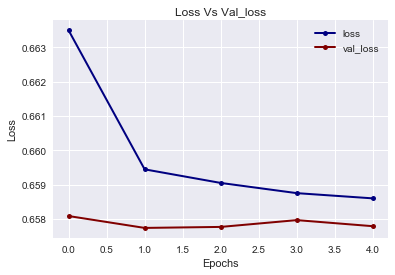

In [122]:
plot_history(w2v_lstm_status_history, loss=True)

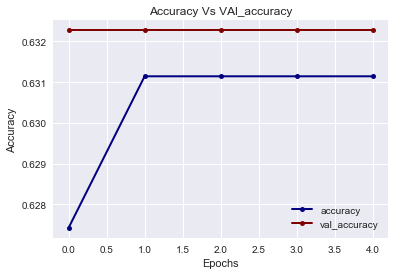

In [123]:
plot_history(w2v_lstm_status_history, loss=False)

#### LSTM - Predict the amount of money collected

In [29]:
model = lstm_model(embedding_layer_keras, classification=False)    
history = train_model(model, train_padded, test_padded, y_train['pledged'], y_test['pledged'])

Epoch 1/20
4562/4562 [==============================] - 588s 128ms/step - loss: 2088656040628.2043 - mse: 2088656040628.2043 - val_loss: 283805057024.0000 - val_mse: 283805057024.0000
Epoch 2/20
4562/4562 [==============================] - 585s 128ms/step - loss: 1864547732435.8467 - mse: 1864547732435.8467 - val_loss: 283805057024.0000 - val_mse: 283805057024.0000
Epoch 3/20
4562/4562 [==============================] - 572s 125ms/step - loss: 1235672922393.6533 - mse: 1235672922393.6533 - val_loss: 283805057024.0000 - val_mse: 283805057024.0000
Epoch 4/20
4562/4562 [==============================] - 600s 131ms/step - loss: 946291842036.1061 - mse: 946291842036.1061 - val_loss: 283805057024.0000 - val_mse: 283805057024.0000


In [30]:
keras_lstm_pledged_history = pd.DataFrame(history.history)
keras_lstm_pledged_history

,loss,mse,val_loss,val_mse
0,2.230456e+12,2.230456e+12,2.838051e+11,2.838051e+11
1,2.230470e+12,2.230470e+12,2.838051e+11,2.838051e+11
2,2.230478e+12,2.230478e+12,2.838051e+11,2.838051e+11
3,2.230480e+12,2.230480e+12,2.838051e+11,2.838051e+11


In [31]:
evaluate_model(model, test_padded, y_test['pledged'])

489/489 [==============================] - 5s 11ms/step - loss: 283804925952.0000 - mse: 283804925952.0000


[283804925952.0, 283804925952.0]

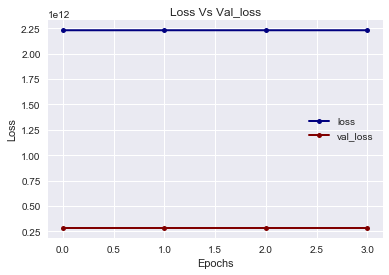

In [92]:
plot_history(keras_lstm_pledged_history, loss=True)

### CNN

In [ ]:
def cnn_model(embeddings, classification=True):
    model = Sequential()
    model.add(embeddings)
    model.add(Conv1D(10, 3, activation='relu', kernel_regularizer=L2(0.1), bias_regularizer=L2(0.9)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))

    adam_opt = Adam(learning_rate=3e-4)
    if classification:
        model.compile(loss="binary_crossentropy", optimizer=adam_opt, metrics=["accuracy"])
    else: 
        model.compile(loss="mean_squared_error", optimizer=adam_opt, metrics=["mse"])
        
    return model 

#### CNN -  Predict if a project/campaign will be successful or not

##### Keras Embeddings 

In [ ]:
model = cnn_model(embedding_layer_keras)    
history = train_model(model, train_padded, test_padded, y_train['state'], y_test['state'])

In [ ]:
keras_cnn_status_history = pd.DataFrame(history.history)
keras_cnn_status_history

In [ ]:
evaluate_model(model, test_padded, y_test['state'])

In [ ]:
plot_history(history)

##### Word2Vec

In [ ]:
model = cnn_model(embedding_layer_w2v)    
history = train_model(model, train_padded, test_padded, y_train['state'], y_test['state'])

In [ ]:
w2v_cnn_status_history = pd.DataFrame(history.history)
w2v_cnn_status_history

In [ ]:
evaluate_model(model, test_padded, y_test['state'])

In [ ]:
plot_history(history)

##### Fasttext

In [ ]:
model = cnn_model(embedding_layer_ft)    
history = train_model(model, train_padded, test_padded, y_train['state'], y_test['state'])

In [ ]:
ft_cnn_status_history = pd.DataFrame(history.history)
ft_cnn_status_history

In [ ]:
evaluate_model(model, test_padded, y_test['state'])

In [ ]:
plot_history(history)

#### CNN - Predict the amount of money collected

In [ ]:
model = lstm_model(embedding_layer_keras, classification=False)    
history = train_model(model, train_padded, test_padded, y_train['pledged'], y_test['pledged'])

In [ ]:
evaluate_model(model, test_padded, y_test['pledged'])

In [ ]:
plot_history(history)

### References

https://radimrehurek.com/gensim/models/word2vec.html

https://keras.io/api/

https://www.youtube.com/watch?v=j7EB7yeySDw&t=600s&ab_channel=DecisionForest